--- 
#Assignment analysis of customer data

*Group 3*


Timo Scheidel (ANR: 175669, SNR: 2010216)

Lorenco Ndoja (ANR: 453393, SNR: 2056363)

Jean Paul Dingemans (ANR: 561450, SNR: 2051504)

Yee Kee Ho (ANR: 828188, SNR: 2048946)

---


In [1]:
from google.colab import drive
drive.mount('/content/drive')
/content/sample_data
"/content/OutTrainF/SPRING2346-D7-V10-H120.png"
"/content/OutTrainF/SPRING2346-D7-V10-H120.png"

Mounted at /content/drive


In [ ]:
pip install surprise

In [ ]:
from requests import get
nb_name = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']


### Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from surprise import NormalPredictor, Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate

from sklearn.neighbors import KDTree
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

from google.colab import drive

from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import RandomizedSearchCV

### Load the data & set data types.






In [ ]:
drive.mount('/content/drive')


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Analysis of Customer Data/ratings.csv", dtype='str')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

dtypes_dict = {'userId': int, 'movieId': int, 'rating':float}
for col, col_dtype in dtypes_dict.items():
    df[col] = df[col].astype(col_dtype)

### Explore the data
---
Let's start with exploring the data. We have no missing values, but with 27 million rows this dataset is huge. 

The first plots show the relative frequency among movieid and userids. Also, it's good to know when the movies were rated to get some general understanding of the dataset. Finally, we want to see how the distribution of the ratings is. 

It is clearly visible that the lower movieIds have a the highest frequency. The density of the movies with MovieIds above +- 10000 is very low or zero. For userIds we don't observe such a pattern. 

--- 




In [ ]:
percent_missing = df.isnull().sum() * 100 / len(df)
unique_users = len(df['userId'].unique())
unique_movies = len(df['movieId'].unique())

print('missing values: ' + str(round(percent_missing['rating'], 2)) + '%')
print('unique users: ' + str(unique_users))
print('unique movies: ' + str(unique_movies))
print()
df

missing values: 0.0%
unique users: 283228
unique movies: 53889



,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


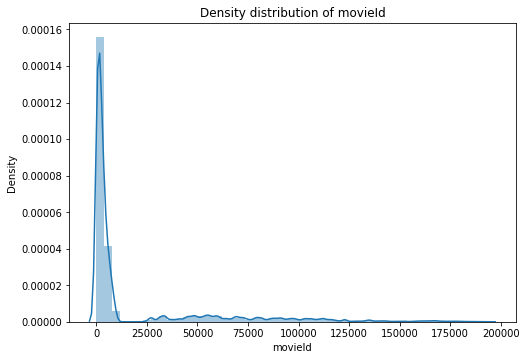

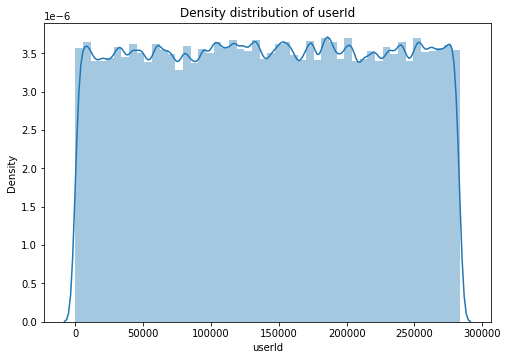

In [ ]:
def plot_density(df, column):
    fig, ax = plt.subplots(figsize=(8,5.5))
    plot = sns.distplot(df[column], kde=True, ax=ax, hist_kws={'edgecolor':'None'})
    plt.title('Density distribution of {}'.format(column))

    
plot_density(df, 'movieId')
plot_density(df, 'userId')

---

In the graphs below we see that most of the ratings are between 3 and 4. Also, there is a increase in frequency for 5-star rating. We see this both in the frequency of the entire dataset, but also for the average rating for individual users. Remarkable is that the average rating for movies show spikes for round / half numbers. This could be explained with the fact that many movies are not frequently rated, otherwise it would be a great coincidence that so many movies have a average rating of .0 or .5. 


In the last graph we see that the dataset is quite recent and spans over many years. This is interesting for the recommender system as the taste of an individual user can change over time. However, considering such information is too complex for this assignment.

---



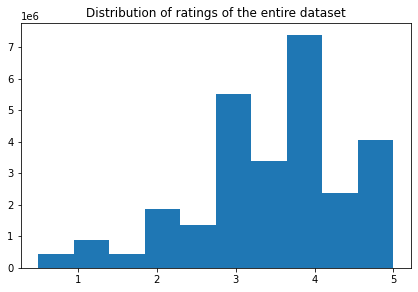

In [ ]:
plt.figure(figsize=(7,4.5))
plt.hist(df['rating'])
plt.title('Distribution of ratings of the entire dataset')
plt.show()

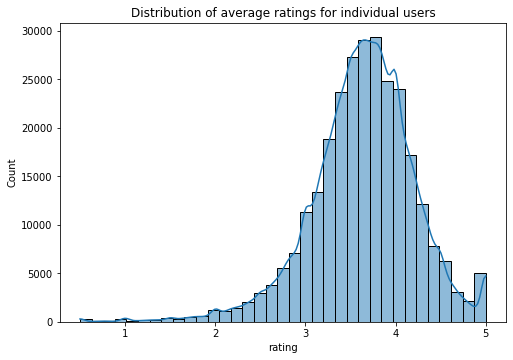

In [ ]:
user_mean = df.groupby(['userId']).mean()
user_mean = user_mean.drop('movieId', axis=1)

fig, ax = plt.subplots(figsize=(8,5.5))
sns.histplot(data=user_mean, x='rating', kde=True, ax=ax, bins=35)
plt.title('Distribution of average ratings for individual users')
plt.show()

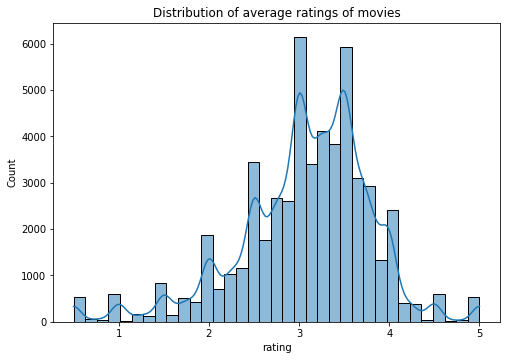

In [ ]:
movie_mean = df.groupby(['movieId']).mean()
movie_mean = movie_mean.drop('userId', axis=1)

fig, ax = plt.subplots(figsize=(8,5.5))
sns.histplot(data=movie_mean, x='rating', kde=True, ax=ax, bins=35)
plt.title('Distribution of average ratings of movies')
plt.show()

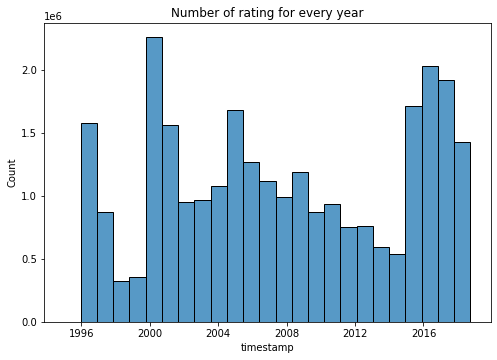

In [ ]:
fig, ax = plt.subplots(figsize=(8,5.5))
#year_df = df['timestamp'].dt.year

sns.histplot(data=df['timestamp'], ax=ax, bins=25)
plt.title('Number of rating for every year')
plt.show()

### Decide on sampling of the dataset
---
In the graph below we see the relative frequency of the top-10000 movies, we chose k=10000 as we saw in the density plot that at maximum 10000 movies had a high frequency. The relative frequenc tends to go to zero for movies outside the top-4000 movies. Unfortunately, experimental results showed that this dataset is way too big for our RAM. It won't be possible to run any of our algorithms with a datasets of this size. Therefore, we decided to use the top 100 movies, using top 200 or higher resulted in crashing our session.

In addition to that, we want to filter out users which rated only a few movies as it is impossible to give an accurate recommendation with so little data. So, we filter out users which rated 3 or less movies

We drop the column with timestamp. Timestamp tell little about the taste of individual users. We delete it to avoid unnecessairy data storage on the main memory.

---




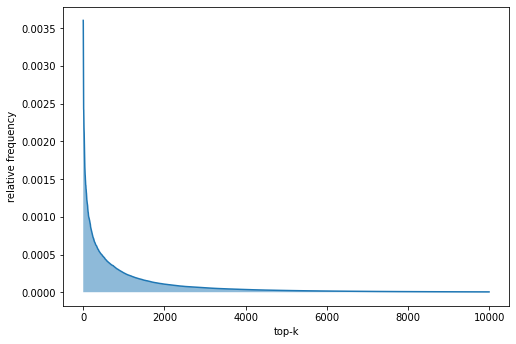

In [ ]:
def plot_frequency(df, column_name, k):
    
    fig, ax = plt.subplots(figsize=(8,5.5))
    counts = df[column_name].value_counts(sort=True, ascending=False)
    orig = counts.index.tolist()
    counts2 = counts.reset_index(inplace=False, drop=True)
    sub = counts2.index.tolist()

    sns.lineplot(x=counts2.index[0:k], y=counts2[0:k]/counts2[0:k].sum(), ax=ax)
    ax.fill_between(counts2.index[0:k], counts2[0:k]/counts2[0:k].sum(), alpha=0.5)
    ax.set_ylabel("relative frequency")
    ax.set_xlabel("top-k")
    

plot_frequency(df, 'movieId', k=10000)

In [ ]:
def select(df, k, col):
    top_values = df[col].value_counts().nlargest(k)
    return df.loc[df[col].isin(top_values.index)]

filtered_df = df.drop('timestamp', axis=1)
filtered_df = select(filtered_df, k=100, col='movieId')

print()
print(filtered_df)
unique_users = len(filtered_df['userId'].unique())
unique_movies = len(filtered_df['movieId'].unique())

print('unique users: ' + str(unique_users))
print('unique movies: ' + str(unique_movies))


          userId  movieId  rating
34             3     1221     4.0
40             3     2028     5.0
42             4        1     4.0
46             4       10     4.0
54             4       32     4.5
...          ...      ...     ...
27753419  283228     3578     5.0
27753422  283228     4886     5.0
27753423  283228     4995     4.0
27753429  283228     6377     5.0
27753430  283228     6874     4.0

[4750245 rows x 3 columns]
unique users: 236818
unique movies: 100


In [ ]:
def filter_values(df, column_name, threshold):
    counts = df[column_name].value_counts()
    index = counts >= threshold
    count_df = counts[index]
    movie_ids = count_df.index.tolist()
    index_filter = df[column_name].isin(movie_ids)
    filtered_df = df[index_filter]
    print('filtered out {}% of the values'.format(100-(filtered_df.size/df.size)*100))
    return filtered_df

filtered_df = filter_values(filtered_df, 'userId', 3)

print()
print(filtered_df)
print()

unique_users = len(filtered_df['userId'].unique())
unique_movies = len(filtered_df['movieId'].unique())

print('unique users: ' + str(unique_users))
print('unique movies: ' + str(unique_movies))

filtered out 1.0248734538955375% of the values

          userId  movieId  rating
42             4        1     4.0
46             4       10     4.0
54             4       32     4.5
55             4       34     3.5
61             4       47     5.0
...          ...      ...     ...
27753419  283228     3578     5.0
27753422  283228     4886     5.0
27753423  283228     4995     4.0
27753429  283228     6377     5.0
27753430  283228     6874     4.0

[4701561 rows x 3 columns]

unique users: 203572
unique movies: 100


### Data distribution of filtered dataset
---
Before we start to perform any recommendations we should compare the sample of the dataset with the original dataset. In the plots below you can see that there are some little changes compared to the original dataset. The relative frequency of lower rating decreases, while the higher ratings are more frequent in the filtered dataset. This is not surprising, high quality movies will have more viewers and thus more ratings. So, higher ratings are a bit overrepresented in the dataset. 

Interesting is to see in the scatterplots is that average rating above 4.25 are extremely rare. They only occur for movies that are rated very infrequent. The filtered dataset is similarily distributed over the x-axis. Obviously, we filtered on frequency so there are only frequently rated movies in the second scatterplot, leaving only instances with high y-values in the scatterplot. 

---


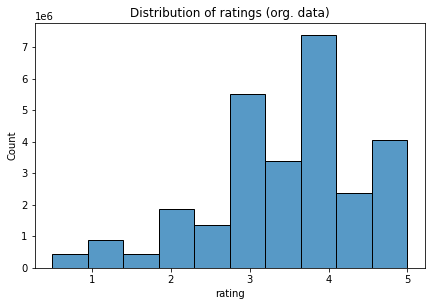

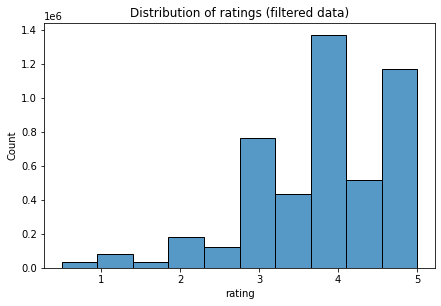

In [ ]:
fig, ax = plt.subplots(figsize=(7,4.5))
sns.histplot(data=df, x='rating', kde=0, ax=ax, bins=10)
plt.title('Distribution of ratings (org. data)')
plt.show()

fig, ax = plt.subplots(figsize=(7,4.5))
sns.histplot(data=filtered_df, x='rating', kde=0, ax=ax, bins=10)
plt.title('Distribution of ratings (filtered data)')
plt.show()

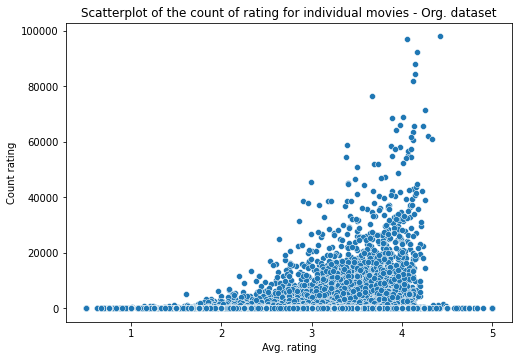

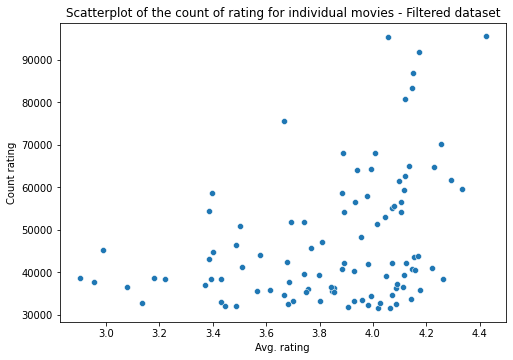

In [ ]:
def scatterplot_count_movies(df, title):
    movie_count = df.groupby(['movieId']).size()
    movie_avg = df.groupby(['movieId']).mean()['rating']
    movie_count = pd.concat([movie_count, movie_avg], axis=1)
    movie_count = movie_count.rename(columns={0: 'Count rating', 'rating':'Avg. rating'})
    movie_count = movie_count.dropna()

    fig, ax = plt.subplots(figsize=(8,5.5))
    sns.scatterplot(x= movie_count['Avg. rating'], y = movie_count['Count rating'], ax=ax)
    plt.title(title)
    plt.show()

scatterplot_count_movies(df, 'Scatterplot of the count of rating for individual movies - Org. dataset')
scatterplot_count_movies(filtered_df, 'Scatterplot of the count of rating for individual movies - Filtered dataset')

### Create a baseline

---
The project description stated that the baseline should be the NormalPredictor. We used cross-validation to find what the RMSE would be of the NormalPredictor on the dataset. We found a **RMSE** of **1.31** for our baseline. 

Note that if we talk about RMSE in this notebook, we always refer to RMSE on the test set.

In [ ]:
### This is the baseline for the models
def baseline(df):
    try:
        df = df.drop('timestamp', axis=1)
    except:
        'Timestamp is not a column'
    
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df, reader)

    baseline_rmse = []
    baseline_rmse.append(cross_validate(NormalPredictor(), data, cv=5, return_train_measures=True)['test_rmse'])
    return np.average(baseline_rmse)



In [ ]:
#baseline_filtered_df = baseline(filtered_df)
print("RMSE of the baseline of the filtered dataset is: {}".format(round(baseline_filtered_df,2)))

RMSE of the baseline of the filtered dataset is: 1.31


# Neighbor method
---

For the neighbor method we used the famous k-nn algorithm. The k-nn algorithm predicts the target value of an instance based on the labels of its k-nearest neighbors. Instances are more nearby if their features have similar values. The hyperparameter k is a number, its ideal value differs for every situation.

Example: A dataset where every row is every instance is a student in a class and average grades are the features. Students are similar when they have similar grades: both a low grade for English and high grades for mathematics & science for example.

Similarity is determined by calculating the distance between instance by using their features. Common options for distance metrics are euclidean, manhattan and minkowski distance. 

The k-nn algorithm of the Surprise package could not manage a dataset of this size, it crashed every time we tried to run it. So we used Sklearn as it does not have this problem, the only disadvantage of using Sklearn is that the GridsearchCV of that package does not include RMSE. We wrote our own code to perform 5-fold CV with some of our configurations. 

We chose to differ the most two most obvious options for hyper-parameter tuning, as they most likely have the biggest impact on performance: 
*   **Distance metrics**:  We chose to use manhattan and euclidean distance. With point x and y the formula are the following:  Manhattan distance: d(x,y) = |x1-y1| + |x2-y2|, Euclidean distance: d(x,y) = sqrt((x1-y1)^2 +(x2-y2)^2)
*   **Number of neighbors**: This parameter is also known as k. The algorithm predicts the label that the majority of the neigbors has. 

**Results**


Ufornutately, the k-nn did not outperform the benchmark. We read that the algorithm does not perform well on this type of problem. However, we found that the algorithm performed better when manhattan distance was used, both for k=3 and k=5. The best configuration of the first run was resulted in a RMSE of 2.93. We managed to improve performance further by increasing the number of neighbors, for this we used manhattan distance. Eventually, k=200 resulted in the lowest RMSE which was 2.24. Further increasing k to 500 negatively affected performance: RMSE increased to 2.26.

We can conclude that the k-nn algorithm is probably not suitable for this task, none of the configurations outperformed random guessing. 

---

In [ ]:
# Preparing the data. The KNN-classifier doesn't take continious labels so we need to use the LabelEncoder.
x = np.array(filtered_df[['userId', 'movieId']])
le = preprocessing.LabelEncoder()
y = np.array(filtered_df['rating'])
le.fit(y)
y = le.transform(y)

# Here we perform 5-fold cross-validation for two configurations of the knn algorithm. 
kf = KFold(n_splits=5)
configurations = np.array([[200,1], [500,1]])

# configurations = np.array([[3,1], [5,1], [3,2], [5,2]])
# output for the configurations above: [3.32, 2.93, 3.70, 3.46]

avg_rmse = []

for config in configurations:
    rmse_config = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]    
        KNN = KNeighborsClassifier(n_neighbors=config[0], p=config[1]).fit(x_train, y_train)
        y_pred = KNN.predict(x_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        rmse_config.append(rmse)
        print(rmse_config)
    avg_rmse.append(np.average(rmse_config))
    print(avg_rmse)

best_conf = np.argmin(avg_rmse)
print('The best configuration is {}'.format(best_conf))

The best configuration is number: 1


# Matrix factorization
---
The selected method based on matrix factorization is singular value decomposition (SVD). It's been chosen based on the current resources and dataset. SVDpp which is notoriously better than SVD has been taken into consideration and run but our computational resources weren't enough to run it in an acceptable time and with an acceptable amount of data. The Hyperparameters of SVD are the number of epochs, number of factors, learning rate, and a regularization term. For this assignment, we considered changing all of these parameters using GridSearch with 5-fold cross-validation. We also tried running a version without the bias term but the performance worsened drastically. After running we saw that the default current value of 0.005 was the best performing. The hyperparameters optimized that we decided to tune for SVD are the number of epochs and factors and the regularization term:
*	**Epochs**: It is the number of iteration of the SGD (stochastic gradient descent) procedure. We tried values between 10 and 120 the optimal number for our model it's 100, 120 performed better but in the order of millesimal.
*	**Factors**: It is used to determine the number of factors to extract/retain during the singular value decomposition, the default value is 100. We tried values between 50 and 200, the one with the lowest RMSE was 150.
*	**Regularization**: It is used to fit the model appropriately and avoid overfitting. We tried values between 0.5 and 0.02. The best performing regularization term for us was 0.01.

We also tried to remove the bias of the SVD, but this resulted in lower-quality predictions. In total with parameters tuning thanks to GridSearch and 5-fold cross-validation, we achieved an **RMSE** of **0.7955**. Besides comparing it with the Normal predictor we decided to compare it with a baseline SVD with a train-test split of 25% which performed RMSE of 0.8150 and another baseline SVD this time with 5-fold cross-validation which performed an RMSE of 0.8090.

---


In [ ]:
sns.set()
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.6, rc={"lines.linewidth": 2})

In [ ]:
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

### SVD model without cross validation

In [ ]:
#SVD model without cross validation - RMSE .81

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

### SVD with Gridsearch and cross validation

In [ ]:
param_grid = {'n_epochs': [100], 'lr_all': [0.005], 'reg_all': [0.1], 'n_factors': [150]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

# Recommender system


The below code does not contribute to the assignment directly but is an example of a practical implementation. The recommender system we build below is a basic implementation of the neighborhood method to recommend movies for each user. 
The system uses the average rating for each user to recommmend movies for other users. To decide which users like the same movies a neighborhood method is used. This average is used to get normalized data because not every user rates the same way. 

To improve the system different parameters could be tested and implemented after the best performing is found.

In [ ]:
Mean = filtered_df.groupby(by="userId",as_index=False)['rating'].mean()
Rating_avg = pd.merge(df,Mean,on='userId')
Rating_avg['adg_rating']=Rating_avg['rating_x']-Rating_avg['rating_y']
Rating_avg.head()

,userId,movieId,rating_x,timestamp,rating_y,adg_rating
0,4,1,4.0,1113765937,4.011628,-0.011628
1,4,2,4.0,1113767306,4.011628,-0.011628
2,4,5,2.0,1123990453,4.011628,-2.011628
3,4,6,4.5,1113767242,4.011628,0.488372
4,4,10,4.0,1113765995,4.011628,-0.011628


In [ ]:
final=pd.pivot_table(Rating_avg[0:100000],values='adg_rating',index='userId',columns='movieId')
final_movie = final.fillna(final.mean(axis=0))
final_movie.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,38,39,40,41,42,...,183161,183179,183295,183605,183607,183611,183635,183803,183805,183815,183897,184015,184239,184253,184257,184471,184797,184937,184987,185029,185169,185989,186325,186331,186347,186587,187031,187481,187593,187595,187601,187613,188213,188309,188449,189333,189363,189399,190085,192005
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,-0.011628,-0.011628,-0.49265,-0.230061,-2.011628,0.488372,-0.694105,0.867857,-0.667929,-0.011628,-0.511628,-1.11743,-0.096415,-0.45265,-1.428026,-0.011628,0.023804,-0.395715,-2.011628,-1.511628,-0.340805,-0.626543,-1.011628,-0.596966,0.488372,-0.623165,0.135925,0.068654,0.17101,0.316711,-1.011628,0.488372,-0.511628,-0.002563,-0.511628,-0.772936,-1.511628,0.02376,0.488372,-1.095843,...,0.581395,-1.705479,0.614583,-0.901515,-0.401515,-0.47381,-0.214286,-0.401515,-0.901515,-1.3,0.682604,-0.507143,-3.050847,0.7,-0.09589,0.111111,0.518519,1.7,-1.214286,-0.418605,-0.4,0.285714,0.416667,1.7,0.416667,-0.214286,-0.85,-0.3,-0.125,-0.574468,0.111111,-0.214286,0.581395,-0.714286,0.2,1.140698,1.35,0.2,0.2,-1.2
5,0.027669,-0.635222,-0.49265,-0.230061,-0.950255,-0.096396,-0.694105,0.867857,-0.667929,-0.330228,-0.265373,-1.11743,-0.096415,-0.45265,-1.428026,0.110555,0.023804,-0.395715,-1.132553,-0.958391,-0.340805,-0.626543,-0.545351,-0.596966,-0.049028,-0.623165,0.135925,0.068654,0.17101,0.316711,-0.783183,0.078513,-0.198303,-0.002563,0.115935,-0.772936,-0.259621,0.02376,0.261585,-1.095843,...,0.581395,-1.705479,0.614583,-0.901515,-0.401515,-0.47381,-0.214286,-0.401515,-0.901515,-1.3,0.682604,-0.507143,-3.050847,0.7,-0.09589,0.111111,0.518519,1.7,-1.214286,-0.418605,-0.4,0.285714,0.416667,1.7,0.416667,-0.214286,-0.85,-0.3,-0.125,-0.574468,0.111111,-0.214286,0.581395,-0.714286,0.2,1.140698,1.35,0.2,0.2,-1.2
6,0.027669,-0.635222,-0.49265,-0.230061,-0.950255,-0.096396,-0.694105,0.867857,-0.667929,0.066667,-0.265373,-1.11743,-0.096415,-0.45265,-1.428026,0.110555,0.023804,-0.395715,-1.132553,-0.958391,0.066667,-0.626543,-0.545351,-0.596966,-0.049028,-0.623165,0.135925,0.068654,0.17101,0.316711,-0.783183,1.066667,-0.198303,-0.002563,0.115935,-0.772936,-0.259621,0.02376,0.261585,-1.095843,...,0.581395,-1.705479,0.614583,-0.901515,-0.401515,-0.47381,-0.214286,-0.401515,-0.901515,-1.3,0.682604,-0.507143,-3.050847,0.7,-0.09589,0.111111,0.518519,1.7,-1.214286,-0.418605,-0.4,0.285714,0.416667,1.7,0.416667,-0.214286,-0.85,-0.3,-0.125,-0.574468,0.111111,-0.214286,0.581395,-0.714286,0.2,1.140698,1.35,0.2,0.2,-1.2
8,0.027669,-0.635222,-0.50000,-0.230061,-0.500000,-0.096396,0.500000,0.867857,-0.667929,-0.330228,-0.265373,-0.50000,-0.096415,-0.50000,-1.428026,0.110555,0.023804,-0.395715,-1.132553,-0.958391,-0.340805,-0.626543,-0.545351,-0.596966,-0.049028,-0.623165,0.135925,0.068654,0.17101,0.316711,-0.783183,0.078513,-0.198303,-0.002563,0.115935,-0.772936,-0.259621,0.02376,0.261585,-1.095843,...,0.581395,-1.705479,0.614583,-0.901515,-0.401515,-0.47381,-0.214286,-0.401515,-0.901515,-1.3,0.682604,-0.507143,-3.050847,0.7,-0.09589,0.111111,0.518519,1.7,-1.214286,-0.418605,-0.4,0.285714,0.416667,1.7,0.416667,-0.214286,-0.85,-0.3,-0.125,-0.574468,0.111111,-0.214286,0.581395,-0.714286,0.2,1.140698,1.35,0.2,0.2,-1.2
10,0.666667,-0.635222,-0.49265,-0.230061,-0.950255,-0.096396,-0.694105,0.867857,-0.667929,-0.330228,-0.265373,-1.11743,-0.096415,-0.45265,-1.428026,0.110555,0.023804,-0.395715,-1.132553,-0.958391,-0.340805,-0.626543,-0.545351,-0.596966,-0.049028,-0.623165,0.135925,0.068654,0.17101,0.316711,-0.783183,-1.333333,-0.198303,-0.002563,0.115935,-0.772936,-0.259621,0.02376,0.261585,-1.095843,...,0.581395,-1.705479,0.614583,-0.901515,-0.401515,-0.47381,-0.214286,-0.401515,-0.901515,-1.3,0.682604,-0.507143,-3.050847,0.7,-0.09589,0.111111,0.518519,1.7,-1.214286,-0.418605,-0.4,0.285714,0.416667,1.7,0.416667,-0.214286,-0.85,-0.3,-0.125,-0.574468,0.111111,-0.214286,0.581395,-0.714286,

In [ ]:
final_user = final.apply(lambda row: row.fillna(row.mean()), axis=1)
final_user.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,38,39,40,41,42,...,183161,183179,183295,183605,183607,183611,183635,183803,183805,183815,183897,184015,184239,184253,184257,184471,184797,184937,184987,185029,185169,185989,186325,186331,186347,186587,187031,187481,187593,187595,187601,187613,188213,188309,188449,189333,189363,189399,190085,192005
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,-0.011628,-0.011628,-0.614209,-0.614209,-2.011628,0.488372,-0.614209,-0.614209,-0.614209,-0.011628,-0.511628,-0.614209,-0.614209,-0.614209,-0.614209,-0.011628,-0.614209,-0.614209,-2.011628,-1.511628,-0.614209,-0.614209,-1.011628,-0.614209,0.488372,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-1.011628,0.488372,-0.511628,-0.614209,-0.511628,-0.614209,-1.511628,-0.614209,0.488372,-0.614209,...,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209,-0.614209
5,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,...,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111,-0.361111
6,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,0.066667,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,0.066667,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,1.066667,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,...,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714,-0.385714
8,-0.145161,-0.145161,-0.500000,-0.145161,-0.500000,-0.145161,0.500000,-0.145161,-0.145161,-0.145161,-0.145161,-0.500000,-0.145161,-0.500000,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,...,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161,-0.145161
10,0.666667,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-0.143251,-

###User similarity on replacing empty values by user avg

In [ ]:
b = cosine_similarity(final_user)
np.fill_diagonal(b, 0 )
similarity_with_user = pd.DataFrame(b,index=final_user.index)
similarity_with_user.columns=final_user.index
similarity_with_user.head()

userId,4,5,6,8,10,11,14,15,16,18,19,22,25,26,27,28,31,32,34,35,36,37,38,39,40,42,43,45,46,47,48,50,51,52,53,54,55,56,57,58,...,1011,1013,1014,1017,1018,1019,1020,1021,1023,1024,1027,1028,1029,1030,1032,1033,1034,1035,1039,1040,1041,1042,1044,1045,1046,1047,1051,1052,1053,1054,1055,1056,1059,1060,1061,1062,1063,1064,1067,1068
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,0.000000,0.864059,0.865339,0.841703,0.735062,0.871295,0.847345,0.787380,-0.840802,0.870422,0.830251,0.868664,0.843465,-0.842027,0.827955,-0.774097,0.820918,0.867061,-0.659108,0.842387,0.625400,0.826778,0.824469,0.841853,0.870490,0.748499,0.757329,0.850185,0.785111,0.657932,0.019247,0.870520,0.810305,0.870919,-0.249526,0.730471,0.858184,0.394330,0.845829,0.849518,...,0.867549,0.136039,0.869870,-0.859040,0.834592,0.867755,-0.860315,0.862975,0.829837,0.204453,0.567827,-0.403721,0.868282,0.724948,-1.105700e-02,0.799276,-0.005436,0.771990,0.850079,0.698690,0.762868,0.870004,0.853626,0.701983,-0.849186,0.811764,0.073666,0.782091,0.871252,0.854520,0.815683,-0.848799,0.414485,0.500020,0.871704,-0.795302,0.851868,0.832263,0.785647,0.751600
5,0.864059,0.000000,0.977774,0.949613,0.829894,0.989723,0.958109,0.896911,-0.958981,0.972578,0.933958,0.986243,0.956143,-0.962942,0.940277,-0.876694,0.936137,0.984640,-0.751489,0.949267,0.697693,0.936642,0.940382,0.954696,0.989273,0.840968,0.857606,0.952470,0.885672,0.738023,0.027527,0.989640,0.918693,0.987436,-0.307329,0.805132,0.972042,0.408436,0.955160,0.965788,...,0.981393,0.147959,0.988271,-0.972434,0.950351,0.977080,-0.978810,0.977771,0.947850,0.228934,0.632475,-0.503681,0.987171,0.809634,0.000000e+00,0.898569,0.002098,0.863203,0.952449,0.799836,0.868769,0.988398,0.960528,0.783219,-0.959231,0.917879,0.078720,0.889835,0.988040,0.960165,0.916714,-0.956732,0.460670,0.553200,0.988415,-0.905999,0.958858,0.927264,0.888030,0.849139
6,0.865339,0.977774,0.000000,0.950261,0.821315,0.985590,0.953094,0.887642,-0.955577,0.974784,0.928346,0.982401,0.948247,-0.958974,0.935934,-0.873358,0.927625,0.980464,-0.748113,0.947628,0.689999,0.934656,0.936733,0.950338,0.985544,0.835033,0.853297,0.948062,0.882570,0.736701,0.014149,0.985785,0.915347,0.983919,-0.304829,0.803747,0.968090,0.409926,0.949024,0.961098,...,0.977889,0.146639,0.984338,-0.966672,0.941017,0.977894,-0.974052,0.974384,0.943334,0.227932,0.628639,-0.503069,0.983310,0.804188,8.673617e-19,0.899527,-0.006132,0.858482,0.951134,0.796163,0.865823,0.984705,0.955364,0.779042,-0.955629,0.911438,0.094204,0.883086,0.984021,0.957581,0.915495,-0.954199,0.460600,0.545014,0.985736,-0.900382,0.960544,0.924239,0.878843,0.854012
8,0.841703,0.949613,0.950261,0.000000,0.799878,0.958205,0.926087,0.862995,-0.930497,0.940520,0.899526,0.955104,0.932578,-0.934332,0.911700,-0.848427,0.903630,0.954807,-0.724948,0.920677,0.670539,0.911792,0.909386,0.923594,0.958498,0.812764,0.828119,0.923101,0.846928,0.713494,0.009176,0.958853,0.891228,0.955843,-0.292384,0.798082,0.941128,0.404173,0.942706,0.935295,...,0.949398,0.143288,0.956866,-0.941777,0.917318,0.945076,-0.946988,0.947127,0.913963,0.227493,0.620394,-0.476978,0.955988,0.785384,-8.673617e-19,0.872550,-0.011737,0.833675,0.919052,0.771908,0.842101,0.958221,0.931355,0.755876,-0.927045,0.884716,0.078040,0.860420,0.956844,0.928909,0.888156,-0.926185,0.453446,0.527543,0.957599,-0.875023,0.929250,0.899234,0.839519,0.819279
10,0.735062,0.829894,0.821315,0.799878,0.000000,0.835207,0.806467,0.742491,-0.807726,0.821080,0.796264,0.832484,0.815604,-0.799112,0.805294,-0.743378,0.799294,0.833872,-0.632672,0.801620,0.606370,0.782846,0.789431,0.806550,0.834107,0.718665,0.738070,0.798669,0.761074,0.641305,0.013343,0.835128,0.780877,0.831992,-0.246332,0.682450,0.817904,0.367787,0.801803,0.821992,...,0.825953,0.141020,0.834101,-0.819859,0.808116,0.822603,-0.820636,0.826157,0.789067,0.209349,0.591207,-0.431658,0.832559,0.676706,0.000000e+00,0.751897,-0.042932,0.731203,0.802505,0.669096,0.742825,0.833649,0.819486,0.664385,-0.814559,0.767834,0

### User similarity on replacing empty values by movie average

In [ ]:
cosine = cosine_similarity(final_movie)
np.fill_diagonal(cosine, 0 )
similarity_with_movie = pd.DataFrame(cosine,index=final_movie.index)
similarity_with_movie.columns=final_user.index
similarity_with_movie.head()

userId,4,5,6,8,10,11,14,15,16,18,19,22,25,26,27,28,31,32,34,35,36,37,38,39,40,42,43,45,46,47,48,50,51,52,53,54,55,56,57,58,...,1011,1013,1014,1017,1018,1019,1020,1021,1023,1024,1027,1028,1029,1030,1032,1033,1034,1035,1039,1040,1041,1042,1044,1045,1046,1047,1051,1052,1053,1054,1055,1056,1059,1060,1061,1062,1063,1064,1067,1068
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,0.000000,0.963657,0.964716,0.964871,0.962636,0.965116,0.964115,0.958600,0.963797,0.965460,0.958245,0.963919,0.965086,0.957851,0.964970,0.964821,0.963018,0.965278,0.959021,0.964754,0.961993,0.964164,0.955485,0.963016,0.965001,0.956671,0.962043,0.959499,0.961928,0.961833,0.961833,0.965285,0.948453,0.965008,0.964139,0.963901,0.943311,0.932571,0.964487,0.964761,...,0.965268,0.964486,0.964286,0.961382,0.963746,0.965115,0.952703,0.964846,0.960975,0.943582,0.959783,0.946072,0.964956,0.956530,0.965513,0.960478,0.965335,0.947090,0.963673,0.949841,0.960879,0.964935,0.958795,0.948498,0.963208,0.962118,0.940059,0.960999,0.964614,0.961444,0.953575,0.964438,0.956432,0.961815,0.965356,0.962322,0.963787,0.962269,0.963158,0.960161
5,0.963657,0.000000,0.997310,0.997710,0.995219,0.998460,0.997205,0.992520,0.997633,0.996634,0.992114,0.996985,0.998128,0.989188,0.998226,0.998018,0.996368,0.998421,0.991816,0.997364,0.993816,0.997450,0.990329,0.996553,0.997984,0.990051,0.995707,0.991259,0.994728,0.993538,0.995239,0.998322,0.982863,0.998081,0.995718,0.996304,0.977125,0.965026,0.997074,0.998244,...,0.998265,0.997945,0.997091,0.995154,0.997405,0.997392,0.984207,0.997580,0.994638,0.979358,0.992623,0.975457,0.998182,0.989715,0.998627,0.993565,0.998501,0.979212,0.997065,0.983915,0.994166,0.998297,0.989398,0.982781,0.997147,0.994488,0.975750,0.994338,0.997433,0.995434,0.985449,0.997916,0.991257,0.994203,0.998210,0.995428,0.996582,0.993848,0.996078,0.993789
6,0.964716,0.997310,0.000000,0.998040,0.995174,0.998429,0.997212,0.992151,0.997803,0.996889,0.991268,0.997100,0.998036,0.989327,0.998310,0.998097,0.996220,0.998527,0.991959,0.997491,0.993779,0.997631,0.990332,0.996612,0.998077,0.990395,0.995748,0.991195,0.994932,0.993572,0.995209,0.998411,0.982861,0.998144,0.995965,0.996488,0.977148,0.965941,0.997181,0.998312,...,0.998333,0.997835,0.997160,0.995092,0.997210,0.997582,0.984621,0.997731,0.994749,0.979547,0.992685,0.975355,0.998267,0.989556,0.998716,0.993573,0.998503,0.978891,0.997038,0.984144,0.994369,0.998390,0.989107,0.983089,0.997145,0.994670,0.976134,0.994455,0.997435,0.995661,0.985685,0.997989,0.991099,0.993831,0.998395,0.995537,0.996951,0.993916,0.995520,0.994380
8,0.964871,0.997710,0.998040,0.000000,0.995524,0.998761,0.997522,0.992447,0.998040,0.997076,0.992174,0.997432,0.998537,0.989601,0.998592,0.998468,0.996518,0.998846,0.992282,0.997824,0.994257,0.997952,0.990519,0.996714,0.998398,0.990844,0.996095,0.991617,0.994973,0.993915,0.995518,0.998737,0.983010,0.998429,0.996251,0.997193,0.977534,0.966393,0.997948,0.998664,...,0.998700,0.998365,0.997485,0.995409,0.997698,0.997810,0.984940,0.998040,0.995013,0.979921,0.993007,0.976053,0.998599,0.990035,0.999048,0.993878,0.998874,0.979221,0.997549,0.984471,0.994715,0.998716,0.989814,0.983481,0.997636,0.994976,0.976065,0.994868,0.997854,0.995888,0.985899,0.998357,0.991368,0.994330,0.998663,0.995870,0.997219,0.994331,0.995916,0.994111
10,0.962636,0.995219,0.995174,0.995524,0.000000,0.996217,0.995072,0.989637,0.995594,0.994464,0.990270,0.994812,0.996198,0.988194,0.996290,0.995815,0.994492,0.996498,0.989980,0.995281,0.992119,0.995163,0.987952,0.994490,0.995894,0.988353,0.993842,0.988860,0.992973,0.991590,0.993060,0.996128,0.981027,0.995954,0.993902,0.994238,0.974294,0.964280,0.994893,0.996328,...,0.996098,0.995925,0.994972,0.992856,0.995521,0.995242,0.982745,0.995585,0.992072,0.977779,0.991350,0.972974,0.996058,0.987243,0.996505,0.991045,0.996264,0.977012,0.994972,0.982009,0.992178,0.996142,0.987518,0.980820,0.994913,0.992227,0.973807,0.992512,0.995288,0.992975,0.983286,0.995834,0.988734,0.991492,0.996122

### Find neighbors

In [ ]:
def find_n_neighbors(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[:n].index, 
          index=['top{}'.format(i) for i in range(1, n+1)]), axis=1)
    return df

sim_user_30_u = find_n_neighbors(similarity_with_user,30)
sim_user_30_u.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,top11,top12,top13,top14,top15,top16,top17,top18,top19,top20,top21,top22,top23,top24,top25,top26,top27,top28,top29,top30
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,437,1061,211,774,298,905,89,338,256,11,231,1053,315,148,730,783,909,512,52,580,851,424,494,528,723,594,693,871,469,74
5,512,774,469,11,783,124,50,851,528,424,315,580,74,392,693,535,909,40,723,905,494,69,211,916,594,89,212,338,405,437
6,512,774,580,392,50,528,1061,783,437,721,74,11,851,693,40,424,212,535,469,739,124,905,211,69,494,909,338,89,228,209
8,190,117,148,451,211,50,535,851,774,40,167,512,354,721,437,209,821,528,74,1042,11,783,580,693,212,424,469,905,89,392
10,123,723,835,821,211,167,162,740,999,124,851,392,987,721,11,74,297,315,50,228,494,105,528,905,774,424,783,820,535,508


In [ ]:
sim_user_30_m = find_n_neighbors(similarity_with_movie,10)
sim_user_30_m

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
userId,,,,,,,,,,
4,437,613,63,935,64,474,918,456,209,344
5,420,879,474,937,142,344,880,1032,975,782
6,879,474,344,1032,880,142,260,937,721,420
8,474,344,1032,879,142,260,880,721,420,975
10,123,375,962,721,344,879,880,474,142,1032
...,...,...,...,...,...,...,...,...,...,...
1062,683,344,1032,474,879,142,880,975,492,420
1063,879,142,880,474,456,344,721,1032,519,937
1064,142,474,879,344,880,519,1032,721,317,209


### Find simular movies 

In [ ]:
def get_user_similar_movies( user1, user2 ):
    common_movies = Rating_avg[Rating_avg.userId == user1].merge(
    Rating_avg[Rating_avg.userId == user2],
    on = "movieId",
    how = "inner" )
    return common_movies

a = get_user_similar_movies(370,1068)
a = a.loc[ : , ['rating_x_x','rating_x_y','movieId']]
a.head()

,rating_x_x,rating_x_y,movieId
0,5.0,3.5,50
1,4.0,3.5,150
2,3.0,3.0,161
3,3.0,3.0,292
4,5.0,4.5,296
